
# **QVANTVS**, *Finite Heterojunction Potential Well Solver for LEDs*, Barbaros Şair

- **QVANTVS** is an open-source software that can calculate the wavefunctions and the corresponding energy levels inside finite-potential quantum wells

- **QVNTVS** solves Time-Independent Schrödinger Equation for finite-potential wells composed of different semiconductor materials (barrier vs. well, heterojunction) using both Finite-Difference numerical method and transcendental graphical-analytical method. 

- The main purpose of this project is facilitating the modeling process of quantum wells that are to be used in
LEDs or LASERs.

- This project is created by Barbaros Şair while working at UNAM (National Nanotechnology Research Centre, Turkey) as an undergraduate researcher in Demir Research Group focusing on Colloidal Quantum Well LEDs.

### 1.Importing Libraries 
- NumPy will be used for calculations requiring linear algebra.
- MatPlotLib will be used to plot the energy levels and wavefunctions.
- SciPy will be used for scientific calculations.

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

### 2.Defining the Parameters
#### 2.1 General Quantum Mechanics Parameters
- h_bar is the modified Planck constant which is present in Schrödinger Equation Hamiltonian.
- eV_to_J is used to convert the energy values from electron Volts to Joules.
- m_e is free electron mass. Inside the crystal lattice structures of solids, free electron mass is modified to have a heavier or lighter value, which is called the effective mass. The effective mass heavily depends on the evaluation of second derivative of E(k) function near the extremum.(Brillouin Zones). 

In [7]:
h_bar = 1.0545718e-34  # J.s
ev_to_J = 1.602176634e-19  # J/eV
m_e = 9.10938356e-31  # kg, free electron mass


#### 2.2 Material-Dependent Parameters
- V_barrier is potential difference in eV. V_barrier can be tuned for different material interfaces.
- eff_e_well and eff_e_barrier are the multipliers of free electron mass for the effective mass inside the well and the barriers.
- well_width_nm and barrier_width_nm are the respective sizes of the structure in nanometers, which are crucial because of the size-dependent phenomenon of the quantum wells.

In [10]:
#Object-Oriented Approach for v2

V_barrier = 0.26 #Potential Barrier Height of InP-InGaAs heterojunction in eV [Tunable]

V0 = V_barrier * ev_to_J # Potential Barrier Height in Joules [Use in Calculations]

eff_e_well = 0.041 #Effective Mass of Electrons in InGaAs in units of free electron mass [m_e] [Tunable]
eff_e_barrier = 0.08 #Effective Mass of Electrons in InP in units of free electron mass [m_e] [Tunable]

m_e_well = eff_e_well * m_e #Effective Mass of Electrons in InGaAs in kg [Use in Calculations]
m_e_barrier = eff_e_barrier * m_e #Effective Mass of Electrons in InP in kg [Use in Calculations]

well_width_nm = 5 #Width of the well in nanometers [Tunable]
well_width = well_width_nm * 1e-9 #Width of the well in meters [Use in Calculations]

barrier_width_nm = 10 #Width of the barrier in nanometers [Tunable]
barrier_width = barrier_width_nm * 1e-9 #Width of the barrier in meters [Use in Calculations]

total_length = well_width + 2 * barrier_width #Total length of the heterojunction in meters [Use in Calculations]

## 3.Computations
### 3.1 Setup
- Setting up the number of intervals and the linear space for the finite-difference numerical method.
- You can increase N for a better resolution (since it is a numerical solution)

In [12]:
N = 2000 #Number of intervals for the finite difference method [Tunable]

x = np.linspace(0, total_length, N) #Linear Space for the finite difference method [Use in Calculations]
dx = x[1] - x[0] #Increment size for the finite difference method [Use in Calculations]


### 3.2 Potential and Effective Mass Profiles Across the Structure
- To assign potentials and effective masses for the each spatial point of the well, we need to specify explicitly 
where does the well starts and ends.
- The coordinates should be indexed to be used for the numerical calculations later.
- V_general reflects the final potential profile of the structure.
- m_general reflects the final effective mass profile of the structure.

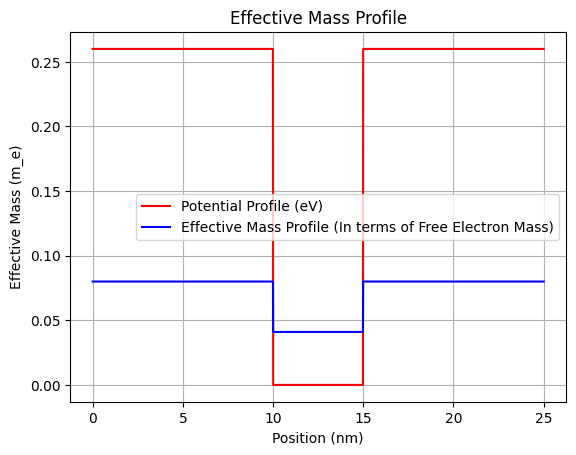

In [38]:
#Defining the spatial coordinates of the well and barriers
well_starting_point = barrier_width #Floating point where the well starts [Will be Modified]
well_ending_point = well_starting_point + well_width #[Will be Modified]

well_start_index = np.argmin(np.abs(x - well_starting_point)) 
well_end_index = np.argmin(np.abs(x - well_ending_point)) #They are indexed to the nearest point in the linear space for numerical calculations 


#Potential Profile
V_general = np.ones(N) * V0 #Setting all the points (N amount) to the potential barrier height 
V_general[well_start_index:well_end_index] = 0 #The potential inside the well is naturally zero 

#Plotting the Potential Profile
plt.plot(x* 1e9, V_general / ev_to_J, label='Potential Profile (eV)', color='red')  
plt.xlabel("Position (nm)")
plt.ylabel("Potential (eV)")
plt.grid(True)
plt.legend()

#Effective Mass Profile
m_general = np.ones(N) * m_e_barrier #Setting all the points (N amount) to the effective mass of the barrier
m_general[well_start_index:well_end_index] = m_e_well #The effective mass inside the well 

#Plotting the Effective Mass Profile (Plotted in terms of free electron mass to show it easier)
plt.plot(x* 1e9, m_general/m_e, label='Effective Mass Profile (In terms of Free Electron Mass)', color='blue')
plt.title("Effective Mass Profile")
plt.xlabel("Position (nm)")
plt.ylabel("Effective Mass (m_e)")
plt.grid(True)
plt.legend()

### 3.3 Inverse Mass Calculations to Fit Generalized Kinetic Energy Operator for Position-Dependent Mass
- The effective mass changes along the coordinates (barrier vs. well), we should use generalized form
of kinetic energy operator used in Time-Independent Schrödinger Equation. 
- Since the effective masses are different for the materials, we should ensure the continiuity of the wavefunction and the inverse mass times the first derivative of the wavefunction.
- Therefore, computing inverse masses at the interfaces (between the grids) is crucial.


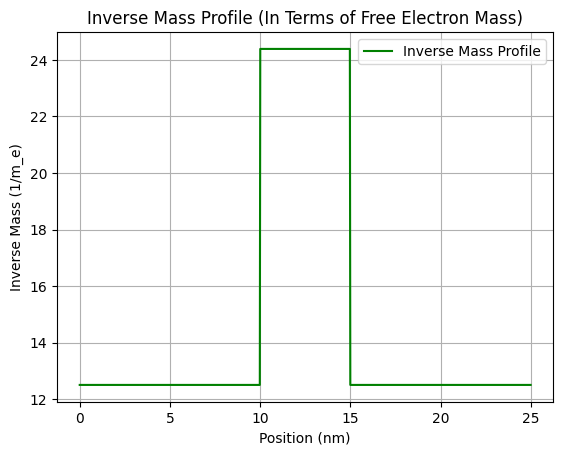

In [49]:
inv_m_general = 1 / m_general #Inverse Mass Profile for the generalized kinetic energy operator
inv_mass = np.zeros(N-1) #There are N-1 between points for N points in the linear space
inv_mass = 0.5 * (inv_m_general[:-1] + inv_m_general[1:]) #Averaging before and after values for each between point

#Plotting the Inverse Mass Profile
plt.plot(x[:-1]* 1e9, inv_mass*m_e, label='Inverse Mass Profile', color='green')
plt.title("Inverse Mass Profile (In Terms of Free Electron Mass)")   
plt.xlabel("Position (nm)")
plt.ylabel("Inverse Mass (1/m_e)")
plt.grid(True)
plt.legend()
plt.show()

### 3.4 Hamiltonian Matrix
### 3.4.1 Energy Levels Calculations
- In Quantum Mechanics, we represent functions as vectors and operators that act on them as matrices. Hamiltonian is the operator that acts on the wavefunction for which the eigenvalues are the corresponding energy values for the eigenfunctions (wavefunctions).
- We will treat Schrödinger Equation as an algebraic equation contrasting with its differential nature. This step introduces finite-difference numerical method to solve the differential equation.
- Ben Daniel-Duke Method
-The derivatives are approximated as a finite difference, and Hamiltonian values are defined for each spatial step.
- The eigenvalues of the Hamiltonian matrix are the energy levels, while the eigenfunctions of the Hamiltonian matrix is the wavefunctions.


  Energy Level 1: 0.090 eV
  Energy Level 2: 0.266 eV
  Energy Level 3: 0.272 eV
  Energy Level 4: 0.318 eV


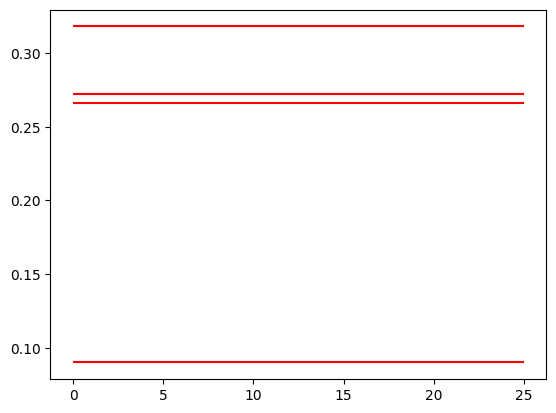

In [81]:
#Negative Definite Laplacian Matrix for the Hamiltonian
#Using the finite difference method to approximate the second derivative

main_diagonal = np.zeros(N)
off_diagonals = np.zeros(N-1)#Initializing the matrices

off_diagonals[:] = -h_bar**2 / (dx**2) * inv_mass / 2 #Replacing all values with the computed values for the off-diagonal elements 

main_diagonal[1:-1] = h_bar**2 / (dx**2) * (inv_mass[1:] + inv_mass[:-1]) / 2 + V_general[1:-1] #For middle points 
main_diagonal[0] = h_bar**2 / (dx**2) * inv_mass[0] / 2 + V_general[0] #For the leftmost spatial point
main_diagonal[-1] = h_bar**2 / (dx**2) * inv_mass[-1] / 2 + V_general[-1] #For the rightmost spatial point

H = np.diag(main_diagonal) + np.diag(off_diagonals, 1) + np.diag(off_diagonals, -1) #Hamiltonian Matrix Approximation

energy_levels, wave_functions = scipy.linalg.eigh(H) #The eigenvalues are the energy levels, and the eigenvectors are the wavefunctions

for i in range(4):
    print(f"  Energy Level {i+1}: {(energy_levels[i]) / ev_to_J:.3f} eV")
    plt.hlines(energy_levels[i]/ev_to_J, x[0]*1e9, x[-1]*1e9, color='r')



### 3.4.2 Wavefunction Calculations and Plots
- For each calculated energy level, we plot their corresponding wavefunction.
- Wavefunctions have a property called normalizability. Their integrals sum up to 1. We normalize these wavefunctions using np.trapezoid function.

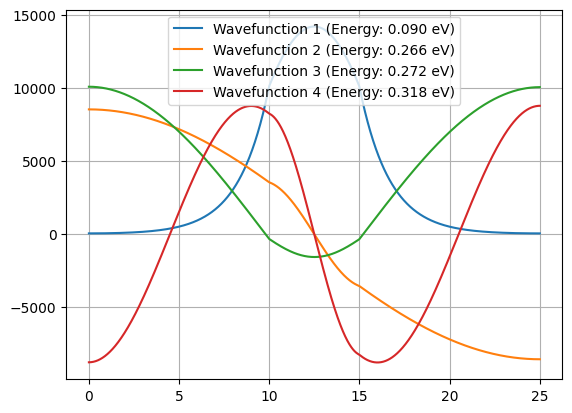

In [83]:
for n in range(4):
    psi = wave_functions[:, n]
    psi /= np.sqrt(np.trapezoid(np.abs(psi)**2, x)) 
    plt.plot(x * 1e9, psi, label=f"Wavefunction {n+1} (Energy: {energy_levels[n] / ev_to_J:.3f} eV)")
plt.legend()
plt.grid(True)
plt.show()


## 4.Conclusion
- To conclude, **QVNTS** calculates the energy-band levels and corresponding wavefunctions for finite-potential wells.
- By changing the parameters of potential height, effective mass, and well thickness, we can model different quantum well structures.
- Though **QVNTVS** .v1 covers only those, in the following versions the overall code will be object-oriented, hole calculations will be added, and electric-field based effects will be simulated to model LEDs in forward-bias mode.